In [1]:
# let's redo the introduction figure
# lets do simulations / images with a crowded field, on the optimised pupil
# probably just calculate fisher info of everything
# / cramer rao bounds as a multiple of airy disk cramer raos

# Core jax
import jax
# from jax.config import config
jax.config.update("jax_enable_x64", True)

import jax.numpy as np
import jax.random as jr

# Optimisation
import zodiax as zdx
import optax

# Optics
import dLux as dl
import dLux.utils as dlu
import dLuxToliman as dlT

# Plotting/visualisation
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from dLuxToliman import ApplyBasisCLIMB, TolimanOpticalSystem

# gonna have to define my own log likelihoods which are analytic contiuations???

from jax.scipy.special import gammaln, xlogy

def poisson_loglike_gamma(k, mu):
    # analytic continuation using gammaln(k+1)
    k = np.asarray(k)
    mu = np.asarray(mu)
    valid = (k >= 0) & np.isfinite(k) & (mu > 0) & np.isfinite(mu)
    logp = xlogy(k, mu) - mu - gammaln(k + 1.0)
    return np.where(valid, logp, -np.inf)

def poisson_loglike_unnormalized(k, mu):
    # returns k*log(mu) - mu  (no normalization constant)
    return xlogy(k, mu) - mu

# define the likelihood function:
def poiss_loglike(pytree, data) -> float:
    """
    Poissonian log likelihood of the pytree given the data. Assumes the pytree
    has a .model() function.

    Parameters
    ----------
    pytree : Base
        Pytree with a .model() function.
    data : Array
        Data to compare the model to.

    Returns
    -------
    log_likelihood : Array
        Log likelihood of the pytree given the data.
    """
    return poisson_loglike_gamma(pytree.model(), data).sum()

plt.rcParams["image.origin"] = 'lower'
plt.rcParams["image.cmap"] = 'magma'

from pathlib import Path

In [49]:
wf_npix = 1024
diameter = 0.125
psf_pixel_scale = 0.375
phase_difference = 0.7*np.pi
period = diameter/64
psf_npix = 450
oversample = 3

apertureLayer = dlT.TolimanApertureLayer(wf_npix)

pupilLayer = dlT.TolimanPupilLayer(wf_npix)

gratingLayer = dlT.PhaseGratingLayer(wf_npix, diameter, period, phase_difference, True)

layers = [
    (
        'aperture',
        apertureLayer
    ),
    (
        'pupil',
        pupilLayer
    ),
    (
        'grating',
        gratingLayer
    )
]

optics = dl.AngularOpticalSystem(wf_npix, diameter, layers, psf_npix, psf_pixel_scale, oversample)

#wavelengths = np.linspace(530e-9, 640e-9, 50)

#source = dl.BinarySource(wavelengths, )
source = dlT.AlphaCen(n_wavels=50, position_angle=100)

model = dl.Telescope(optics, source)

image = model.model()

pupil = optics.pupil.phase
pupil /= np.max(pupil)
pupil *= 2
pupil += -1 
pupil *= optics.aperture.transmission

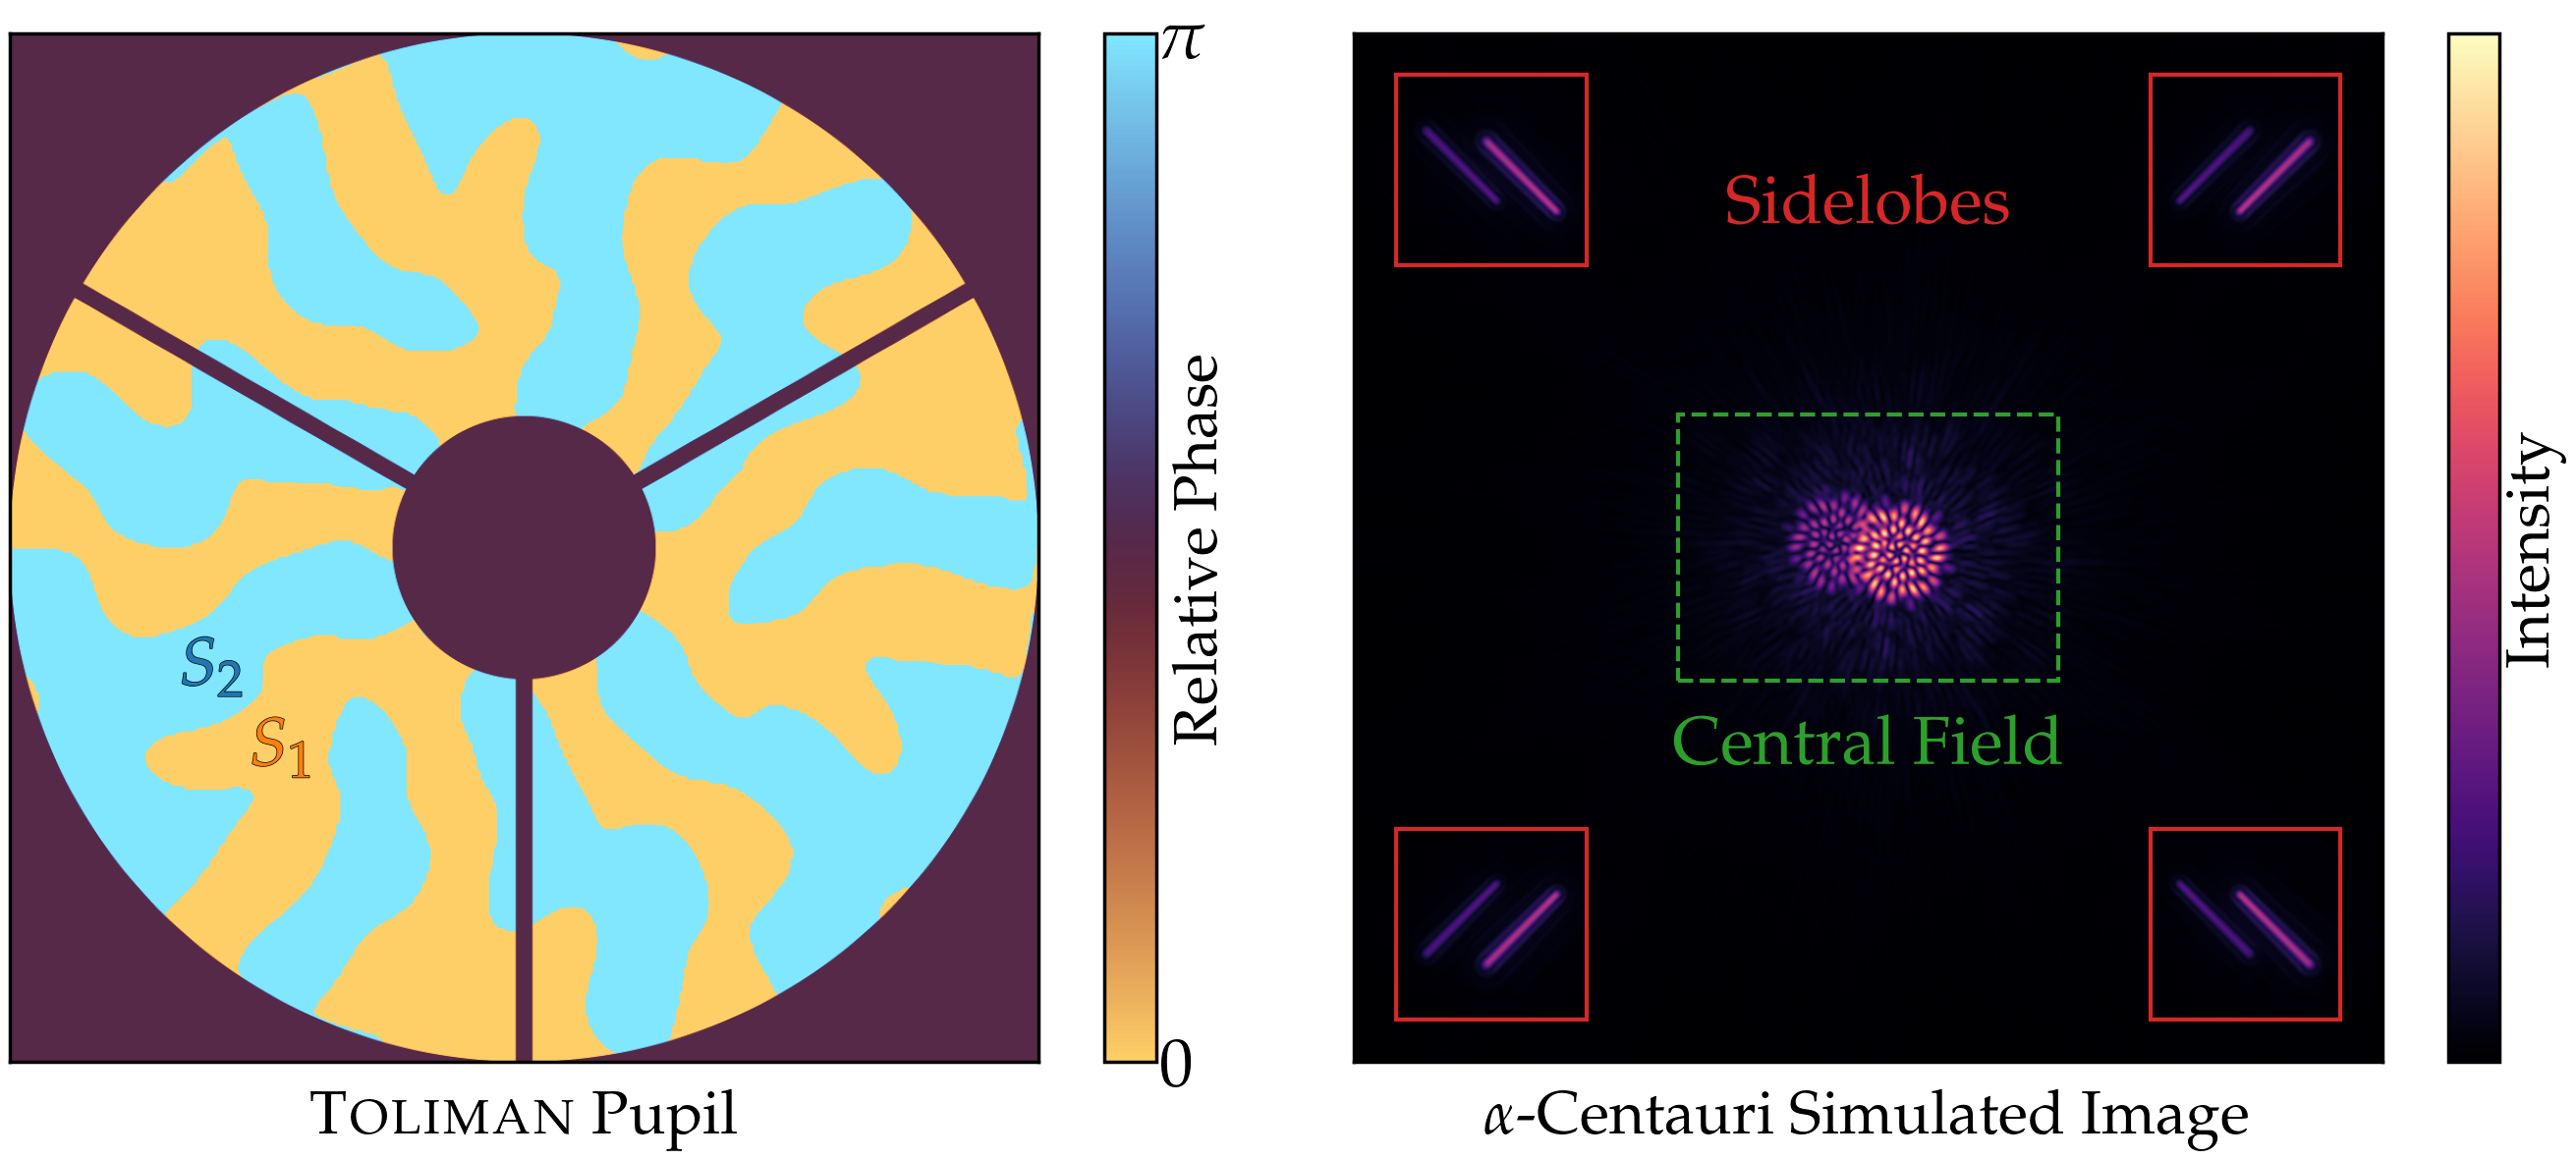

In [107]:
plt.style.use('../wk17/sty.mplstyle')
plt.rcParams["image.cmap"] = 'magma'
plt.rcParams["image.origin"] = 'lower'

import matplotlib.patheffects as pe
text_path_effects=[pe.Stroke(linewidth=1, foreground='k'), pe.Normal()]
path_effects = [pe.Stroke(linewidth=6, foreground='k'), pe.Normal()]
from matplotlib.patches import Rectangle

plt.figure(figsize=(28,12))

plt.subplot(1,2,1)
plt.imshow(pupil, cmap='managua', origin='lower')
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar()
cbar.set_ticks([-1,1])
cbar.set_ticklabels(['0',r'$\pi$'],fontsize=50)
cbar.set_label('Relative Phase', labelpad=-25)
plt.xlabel(r'\textsc{Toliman} Pupil', labelpad=20)
plt.text(270,310,
         r'$S_1$', color = 'tab:orange', fontsize=50, ha='center',va='center', path_effects=text_path_effects)

plt.text(200,390,
         r'$S_2$', color = 'tab:blue', fontsize=50, ha='center',va='center', path_effects=text_path_effects)

ax = plt.subplot(1,2,2)
plt.imshow(image**0.5, cmap='magma', origin='lower')
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar()
cbar.set_ticks([])
cbar.set_label('Intensity')
plt.xlabel(r'$\alpha$-Centauri Simulated Image',labelpad=20)
plt.text(675,410,
         r'Central Field', color='tab:green', fontsize=50, ha='center', va='center', path_effects=text_path_effects)

plt.text(675,1120,
         r'Sidelobes', color='tab:red', fontsize=50, ha='center', va='center', path_effects=text_path_effects)

# adding rectangles
width = 250
height = 250
lower_left = (180 - width/2, 180 - height/2)

rect = Rectangle(lower_left, width, height,
                 edgecolor='tab:red', facecolor='none',
                 linewidth=3, linestyle='-', zorder=4, path_effects=text_path_effects)
ax.add_patch(rect)

lower_left = (1170 - width/2, 180 - height/2)

rect = Rectangle(lower_left, width, height,
                 edgecolor='tab:red', facecolor='none',
                 linewidth=3, linestyle='-', zorder=4, path_effects=text_path_effects)
ax.add_patch(rect)

lower_left = (1170 - width/2, 1170 - height/2)

rect = Rectangle(lower_left, width, height,
                 edgecolor='tab:red', facecolor='none',
                 linewidth=3, linestyle='-', zorder=4, path_effects=text_path_effects)
ax.add_patch(rect)

lower_left = (180 - width/2, 1170 - height/2)

rect = Rectangle(lower_left, width, height,
                 edgecolor='tab:red', facecolor='none',
                 linewidth=3, linestyle='-', zorder=4, path_effects=text_path_effects)
ax.add_patch(rect)

# adding central field rectangle
width = 500
height = 350
lower_left = (675 - width/2, 675 - height/2)

rect = Rectangle(lower_left, width, height,
                 edgecolor='tab:green', facecolor='none',
                 linewidth=3, linestyle='--', zorder=4, path_effects=text_path_effects)
ax.add_patch(rect)

plt.tight_layout()
#plt.savefig('introfig.pdf',dpi=300,bbox_inches='tight')
plt.show()